In [303]:
import torch
import torch.nn.functional as F
import json, copy
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

In [304]:
from tqdm import tqdm
from functools import reduce

In [305]:
project_dir = "/home/miskai/デスクトップ/related-work/scene-graph-benchmark"
image_file = json.load(open(f'{project_dir}/datasets/vg/image_data.json'))
vocab_file = json.load(open(f'{project_dir}/datasets/vg/VG-SGG-dicts-with-attri.json'))
data_file = h5py.File(f'{project_dir}/datasets/vg/VG-SGG-with-attri.h5', 'r')
# remove invalid image
corrupted_ims = [1592, 1722, 4616, 4617]
tmp = []
for item in image_file:
    if int(item['image_id']) not in corrupted_ims:
        tmp.append(item)
image_file = tmp

In [306]:
kt_result_path = '/home/miskai/デスクトップ/related-work/scene-graph-benchmark/SGG-TD2/checkpoints/knowledgetrans-motifs-predcls-exmp-2cluster/RELU/concat_margin40_from_record_cls0.1'
detected_origin_path = f'{kt_result_path}/inference/VG_stanford_filtered_with_attribute_test/'
kt_result = torch.load(detected_origin_path + 'eval_results.pytorch')
kt_info = json.load(open(detected_origin_path + 'visual_info.json'))

In [5]:
nokt_result_path = '/home/miskai/デスクトップ/related-work/scene-graph-benchmark/SGG-TD2/checkpoints/motifs-predcls-exmp/RELU/concat-less-lr0.001'
detected_origin_path = f'{nokt_result_path}/inference/VG_stanford_filtered_with_attribute_test/'
nokt_result = torch.load(detected_origin_path + 'eval_results.pytorch')
nokt_info = json.load(open(detected_origin_path + 'visual_info.json'))

In [307]:
pred2idx = vocab_file["predicate_to_idx"]
idx2pred = vocab_file["idx_to_predicate"]
labels = [idx2pred[str(i)] for i in range(1,51)]

In [308]:
def bbox_iou(a,b):
    xA = max(a[0], b[0])
    yA = max(a[1], b[1])
    xB = min(a[2], b[2])
    yB = min(a[3], b[3])
    intra_area = max(0, xB-xA+1)*max(0, yB-yA+1)
    a_area = (a[2]-a[0]+1)*(a[3]-a[1]+1)
    b_area = (b[2]-b[0]+1)*(b[3]-b[1]+1)
    iou = intra_area/float(a_area+b_area-intra_area)
    return iou

In [117]:
def bbox_match(pred, gt):
    """Args:
        pred: [x0, y0, x1, y1]
        gt: same as above
    Returns: whether objects in gt and prediction are seen as same objects
    """
    iou = bbox_iou(pred, gt)
    return iou>0.5

In [118]:
def find_match(pred_rels, gt_rels):
    """
    pred_rels, gt_rels: relation triplets
        sub_label: label of subject (String)
        obj_label: label of object  (String)
        sub_bbox:  bbox of subject  ([num_rel, 4])
        obj_bbox:  bbox of object   ([num_rel, 4])
        rel_label: relation label   (Int)
    """
    pred_match = [[] for _ in range(len(gt_rels))]
    is_correct = np.array([0 for _ in range(len(gt_rels))])
    for i, gt in enumerate(gt_rels):
        for pre in pred_rels:
            if pre["sub_label"]==gt["sub_label"] and pre["obj_label"]==gt["obj_label"] and bbox_match(pre["sub_bbox"],gt["sub_bbox"] ) and bbox_match(pre["obj_bbox"], gt["obj_bbox"]):
                if pre["rel_label"] == gt["rel_label"]:
                    pred_match[i] = [pre]
                    is_correct[i] = 1
                    break
                else:
                    pred_match[i].append(pre)
    return np.array(pred_match), is_correct

In [119]:
def analyze_one_image(result, idx):
    prediction = result["predictions"][idx]
    groundtruths = result["groundtruths"][idx]
    idx2label = vocab_file['idx_to_label']
    idx2pred = vocab_file['idx_to_predicate']
    # ground truth boxes
    gt_boxes = groundtruths.bbox
    # ground truth label corresponding to bbox above
    gt_labels = groundtruths.get_field("labels").tolist()
    # rel pair lists
    pred_rels = []
    gt_rels =[]
    # ground truth triplet
    gt_triplets = groundtruths.get_field('relation_tuple').tolist()
    for tri in gt_triplets:
        tmp = {}
        tmp["sub_label"] = idx2label[str(gt_labels[tri[0]])]
        tmp["obj_label"] = idx2label[str(gt_labels[tri[1]])]
        tmp["sub_bbox"] = gt_boxes[tri[0]].tolist()
        tmp["obj_bbox"] = gt_boxes[tri[1]].tolist()
        tmp["rel_label"] = idx2pred[str(tri[2])]
        gt_rels.append(tmp)
    
    # prediction relation triplet
    # prediction boxes
    pred_boxes = prediction.bbox
    # predicted object label corresponding to bbox above
    pred_labels = prediction.get_field("pred_labels").long().tolist()
    # relation probabilties
    pred_rel_prob = prediction.get_field("pred_rel_scores").tolist()
    # relation pair
    pred_rel_pair = prediction.get_field('rel_pair_idxs').long().tolist()
    # relation label
    pred_rel_label = prediction.get_field('pred_rel_labels').long()[:100]
    for idx, (j, k) in enumerate(zip(pred_rel_pair, pred_rel_label.tolist())):
        tmp = {}
        tmp["sub_label"] = idx2label[str(pred_labels[j[0]])]
        tmp["obj_label"] = idx2label[str(pred_labels[j[1]])]
        tmp["sub_bbox"] = pred_boxes[j[0]].tolist()
        tmp["obj_bbox"] = pred_boxes[j[1]].tolist()
        tmp["rel_label"] = idx2pred[str(k)]
        tmp["prob"] = pred_rel_prob[idx]
        pred_rels.append(tmp)
    pred_match, is_correct = find_match(pred_rels, gt_rels)
    return pred_match, is_correct, gt_rels

In [120]:
def comp_kt_nokt(kt_result, nokt_result,idx):
    kt_match, kt_is_correct, gt_rels = analyze_one_image(kt_result, idx)
    nokt_match, nokt_is_correct, _ = analyze_one_image(nokt_result, idx)
    kt_sup_mask = (kt_is_correct-nokt_is_correct)>0
    nokt_sup_mask = (nokt_is_correct-kt_is_correct)>0
    cant_imp_mask = (1-kt_is_correct)*(1-nokt_is_correct)>0
    kt_sup_exmp = {"kt":kt_match[kt_sup_mask],"nokt":nokt_match[kt_sup_mask]}
    nokt_sup_exmp = {"kt":kt_match[nokt_sup_mask],"nokt":nokt_match[nokt_sup_mask]}
    cant_imp_exmp = {"kt":kt_match[cant_imp_mask], "nokt":nokt_match[cant_imp_mask], "gt":np.array(gt_rels)[cant_imp_mask]}
    return kt_sup_exmp, nokt_sup_exmp, cant_imp_exmp

In [121]:
kt_sup_dict = dict(zip([idx2pred[str(i)] for i in range(1,51)], [[] for _ in range(51)]))
nokt_sup_dict = dict(zip([idx2pred[str(i)] for i in range(1,51)], [[] for _ in range(51)]))
cant_imp_dict = dict(zip([idx2pred[str(i)] for i in range(1,51)], [[] for _ in range(51)]))
for i in tqdm(range(20000)):
# for i in tqdm(range(26446)):
    kt_sup_exmp, nokt_sup_exmp, cant_imp_exmp = comp_kt_nokt(kt_result, nokt_result, i)
    if len(kt_sup_exmp["kt"])>0:
        for kt, nokt in zip(kt_sup_exmp["kt"], kt_sup_exmp["nokt"]):
            if len(nokt)==0: continue
            rel_label = kt[0]["rel_label"]
            ious = [bbox_iou(kt[0]["sub_bbox"], tmp["sub_bbox"])*bbox_iou(kt[0]["obj_bbox"], tmp["obj_bbox"]) for tmp in nokt]
            res = {"idx":i, "kt":kt[0], "nokt":nokt[np.argmax(ious)]}
            kt_sup_dict[rel_label].append(res)
    
    if len(nokt_sup_exmp["kt"])>0:
        for kt, nokt in zip(nokt_sup_exmp["kt"], nokt_sup_exmp["nokt"]):
            if len(kt)==0:continue
            rel_label = nokt[0]["rel_label"]
            ious = [bbox_iou(nokt[0]["sub_bbox"], tmp["sub_bbox"])*bbox_iou(nokt[0]["obj_bbox"], tmp["obj_bbox"]) for tmp in kt]
            res = {"idx":i, "kt":kt[np.argmax(ious)], "nokt":nokt[0]}
            nokt_sup_dict[rel_label].append(res)
        
    if len(cant_imp_exmp["kt"])>0:
        gt = cant_imp_exmp["gt"]
        for l, (kt, nokt) in enumerate(zip(cant_imp_exmp["kt"], cant_imp_exmp["nokt"])):
            if len(kt)==0:continue
            rel_label = gt[l]["rel_label"]
            kt_ious = [bbox_iou(gt[l]["sub_bbox"], tmp["sub_bbox"])*bbox_iou(gt[l]["obj_bbox"], tmp["obj_bbox"]) for tmp in kt]
            if len(nokt)==0:
                res = {"idx":i, "gt": gt[l], "kt":kt[np.argmax(kt_ious)], "nokt":None}
            else:
                nokt_ious = [bbox_iou(gt[l]["sub_bbox"], tmp["sub_bbox"])*bbox_iou(gt[l]["obj_bbox"], tmp["obj_bbox"]) for tmp in nokt]
                res = {"idx":i, "gt": gt[l], "kt":kt[np.argmax(kt_ious)], "nokt":nokt[np.argmax(nokt_ious)]}
            cant_imp_dict[rel_label].append(res)

100%|██████████| 20000/20000 [00:31<00:00, 628.49it/s]


## kt superior analysis

In [122]:
for l in labels:
    if kt_sup_dict[l]!=[]:
        print(f"{l}:{len(kt_sup_dict[l])}")

above:151
across:3
against:2
along:15
and:5
at:3
attached to:25
behind:165
belonging to:10
between:12
carrying:112
covered in:34
covering:14
eating:49
for:49
from:1
growing on:6
hanging from:33
has:351
holding:183
in:378
in front of:92
laying on:2
looking at:16
lying on:1
mounted on:4
near:486
of:999
on:2074
on back of:5
over:34
painted on:1
parked on:100
part of:1
playing:1
riding:165
sitting on:24
standing on:99
to:15
under:78
using:21
walking in:6
walking on:52
watching:2
wearing:76
wears:49
with:656


In [184]:
predicate = "standing on"

In [295]:
exmp = kt_sup_dict[predicate][33]
idx = exmp["idx"]
kt = exmp["kt"]
nokt = exmp["nokt"]

In [296]:
print(f"image:{idx}")
sub = kt["sub_label"]
obj = kt["obj_label"]
print(f"{sub}-{obj}")
gt_label = kt["rel_label"]
kt_prob = kt["prob"]
kt_label = kt["rel_label"]
nokt_prob = nokt["prob"]
nokt_label = nokt["rel_label"]

image:7102
man-snow


kt prediction: sitting on
sitting on probability: 0.0980440154671669


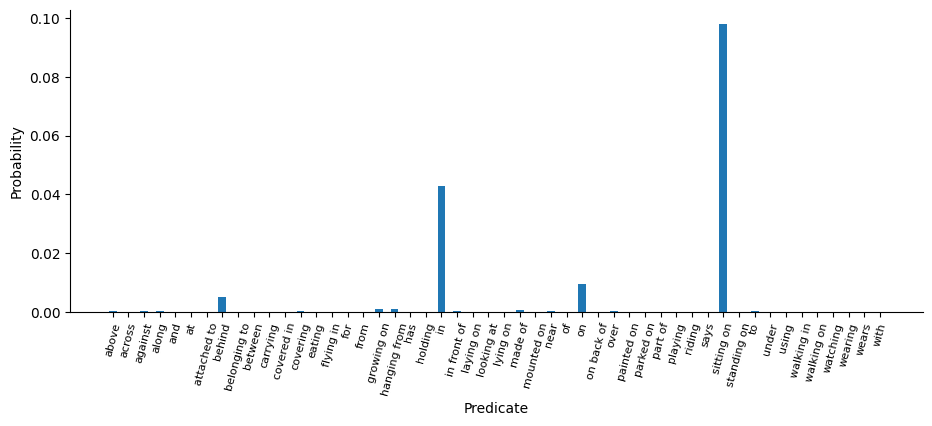

In [134]:
print(f"kt prediction: {kt_label}")
print(f"{gt_label} probability: {kt_prob[pred2idx[gt_label]]}")
label = [idx2pred[str(i)] for i in range(1,51)]
left = [100*i for i in range(50)]
height = kt_prob[1:]
fig = plt.figure(figsize=(11,4), dpi=100)
plt.xticks(fontsize=8)
plt.xticks(rotation=75)
plt.xlabel("Predicate")
plt.ylabel("Probability")
# plt.ylim([0,0.2])
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.bar(left, height, width=50, tick_label=label, align="center")
plt.show()

nokt prediction: on
standing on probability: 0.06048170104622841


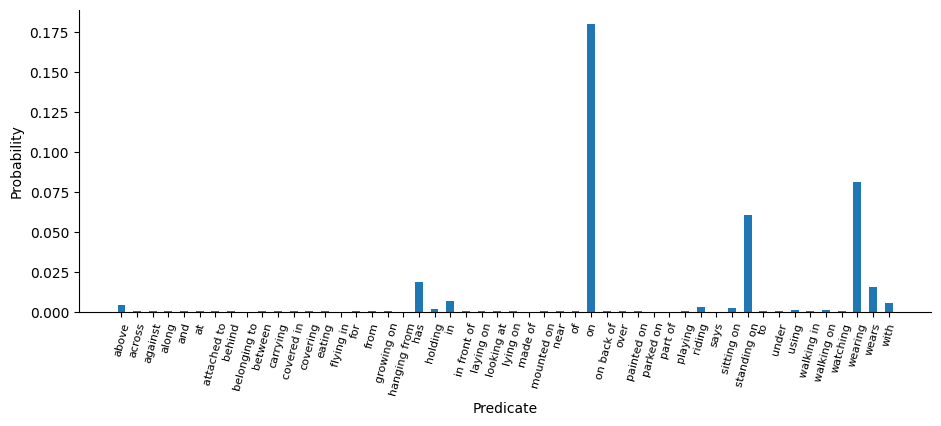

In [36]:
print(f"nokt prediction: {nokt_label}")
print(f"{gt_label} probability: {nokt_prob[pred2idx[gt_label]]}")
label = [idx2pred[str(i)] for i in range(1,51)]
left = [100*i for i in range(50)]
height = nokt_prob[1:]
fig = plt.figure(figsize=(11,4), dpi=100)
plt.xticks(fontsize=8)
plt.xticks(rotation=75)
plt.xlabel("Predicate")
plt.ylabel("Probability")
# plt.ylim([0,0.2])
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.bar(left, height, width=50, tick_label=label, align="center")
plt.show()

## failure analysis

In [271]:
for l in labels:
    if cant_imp_dict[l]!=[]:
        print(f"{l}:{len(cant_imp_dict[l])}")

above:136
across:5
against:4
along:8
and:9
at:9
attached to:23
behind:50
belonging to:10
between:7
carrying:23
covered in:5
covering:3
eating:9
flying in:20
for:14
from:3
growing on:8
hanging from:22
has:165
holding:53
in:234
in front of:49
laying on:14
looking at:7
lying on:5
made of:1
mounted on:3
near:150
of:164
on:327
on back of:9
over:14
painted on:6
parked on:18
part of:9
riding:64
says:2
sitting on:62
standing on:48
to:10
under:42
using:7
walking in:1
walking on:16
watching:9
wearing:16
wears:77
with:146


In [276]:
exmp = cant_imp_dict["flying in"][1]
idx = exmp["idx"]
gt = exmp["gt"]
kt = exmp["kt"]
nokt = exmp["nokt"]

In [277]:
print(f"image:{idx}")
sub = gt["sub_label"]
obj = gt["obj_label"]
print(f"{sub}-{obj}")
gt_label = gt["rel_label"]
kt_prob = kt["prob"]
kt_label = kt["rel_label"]
nokt_prob = nokt["prob"]
nokt_label = nokt["rel_label"]

image:284
kite-kite


kt prediction: above
flying in probability: 4.587351298823705e-08


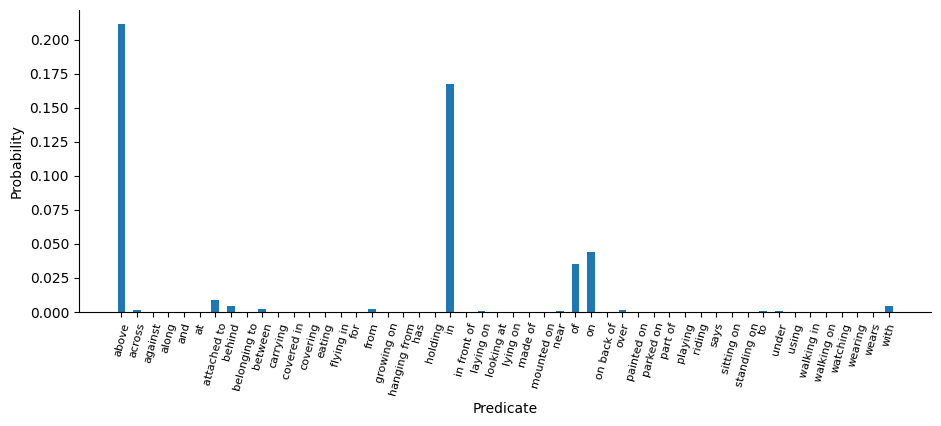

In [278]:
print(f"kt prediction: {kt_label}")
print(f"{gt_label} probability: {kt_prob[pred2idx[gt_label]]}")
label = [idx2pred[str(i)] for i in range(1,51)]
left = [100*i for i in range(50)]
height = kt_prob[1:]
fig = plt.figure(figsize=(11,4), dpi=100)
plt.xticks(fontsize=8)
plt.xticks(rotation=75)
plt.xlabel("Predicate")
plt.ylabel("Probability")
# plt.ylim([0,0.2])
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.bar(left, height, width=50, tick_label=label, align="center")
plt.show()

nokt prediction: on
flying in probability: 9.519930245005526e-06


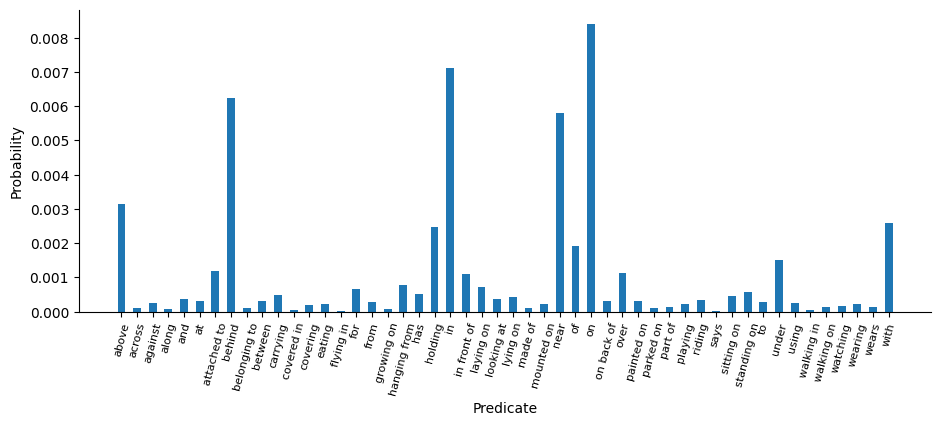

In [279]:
print(f"nokt prediction: {nokt_label}")
print(f"{gt_label} probability: {nokt_prob[pred2idx[gt_label]]}")
label = [idx2pred[str(i)] for i in range(1,51)]
left = [100*i for i in range(50)]
height = nokt_prob[1:]
fig = plt.figure(figsize=(11,4), dpi=100)
plt.xticks(fontsize=8)
plt.xticks(rotation=75)
plt.xlabel("Predicate")
plt.ylabel("Probability")
# plt.ylim([0,0.2])
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.bar(left, height, width=50, tick_label=label, align="center")
plt.show()

# 

# visualize

In [309]:
# get image info by index
def get_info_by_idx(idx, det_input, det_info, thres=0.5):
    groundtruth = det_input['groundtruths'][idx]
    prediction = det_input['predictions'][idx]
    # image path
    img_path = det_info[idx]['img_file']
    if img_path.startswith("/home/acd13805eb/SGG/SGG-TD2"):
        img_path = img_path.replace("/home/acd13805eb/SGG/SGG-TD2", "/home/miskai/デスクトップ/related-work/scene-graph-benchmark")
    print(img_path)
    # boxes
    boxes = prediction.bbox
    # object labels
    idx2label = vocab_file['idx_to_label']
    labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(groundtruth.get_field('labels').tolist())]
    pred_labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(prediction.get_field('pred_labels').tolist())]
    pred_scores = prediction.get_field('pred_scores').tolist()[:100]
    # groundtruth relation triplet
    idx2pred = vocab_file['idx_to_predicate']
    gt_rels = groundtruth.get_field('relation_tuple').tolist()
    gt_rels = [(labels[i[0]], idx2pred[str(i[2])], labels[i[1]]) for i in gt_rels]
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').tolist()
    pred_rel_label = prediction.get_field('pred_rel_labels')[:100]
    pred_rel_score = prediction.get_field("pred_rel_max_scores").tolist()[:100]
    pred_rels = [(pred_labels[i[0]], idx2pred[str(j)], pred_labels[i[1]]) for i, j in zip(pred_rel_pair, pred_rel_label.tolist())]
    return img_path, boxes, labels, pred_labels, pred_scores, gt_rels, pred_rels, pred_rel_score, pred_rel_label

In [310]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)

def print_list(name, input_list, scores, gt_rels=None):
    for i, item in enumerate(input_list):
        if scores == None:
            print(name + ' ' + str(i) + ': ' + str(item))
        else:
            # it works  just in predcls or sgdet
            c = "\033[30m"
            if gt_rels:
                for sub, rel, obj in gt_rels:
                    if item[0]==sub and item[2]==obj:
                        if item[1]==rel: 
                            c = "\033[32m"
                            break
                        else: c = "\033[31m"
            print(c + name + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i]) + "\033[0m") 
    
def draw_image(img_path, boxes, labels, pred_labels, pred_scores, gt_rels, pred_rels, pred_rel_score, pred_rel_label, print_img=True):
    pic = Image.open(img_path)
    num_obj = boxes.shape[0]
    for i in range(num_obj):
        info = pred_labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    if print_img:
        display(pic)
    if print_img:
        # print('*' * 50)
        # print_list('gt_boxes', labels, None)
        print('*' * 50)
        print_list('gt_rels', gt_rels, None)
        print('*' * 50)
    print_list('pred_labels', pred_labels, pred_rel_score)
    print('*' * 50)
    print_list('pred_rels', pred_rels, pred_rel_score, gt_rels=gt_rels)
    print('*' * 50)
    
    return None

In [311]:
def show_selected(idx_list, result, info):
    for select_idx in idx_list:
        print(select_idx)
        draw_image(*get_info_by_idx(select_idx, result, info))
        
def show_all(start_idx, length, result, info):
    for cand_idx in range(start_idx, start_idx+length):
        print(f'Image {cand_idx}:')
        img_path, boxes, labels, pred_labels, pred_scores, gt_rels, pred_rels, pred_rel_score, pred_rel_label = get_info_by_idx(cand_idx, result, info)
        draw_image(img_path=img_path, boxes=boxes, labels=labels, pred_labels=pred_labels, pred_scores=pred_scores, gt_rels=gt_rels, pred_rels=pred_rels, pred_rel_score=pred_rel_score, pred_rel_label=pred_rel_label, print_img=True)

Image 1:
/home/miskai/デスクトップ/related-work/scene-graph-benchmark/datasets/vg/VG_100K/2343728.jpg


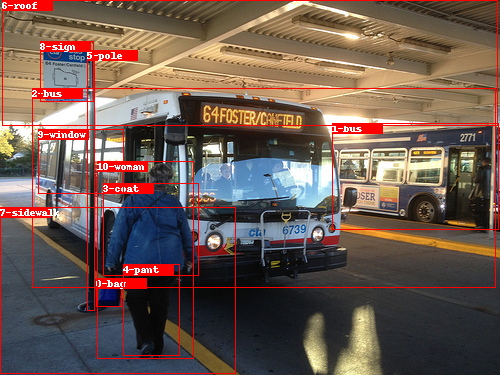

**************************************************
gt_rels 0: ('2-bus', 'under', '6-roof')
gt_rels 1: ('10-woman', 'near', '2-bus')
gt_rels 2: ('9-window', 'on', '2-bus')
gt_rels 3: ('10-woman', 'wearing', '3-coat')
**************************************************
pred_labels 0: 0-bag; score: 0.42131146788597107
pred_labels 1: 1-bus; score: 0.37329426407814026
pred_labels 2: 2-bus; score: 0.36104458570480347
pred_labels 3: 3-coat; score: 0.33101481199264526
pred_labels 4: 4-pant; score: 0.23089994490146637
pred_labels 5: 5-pole; score: 0.12495345622301102
pred_labels 6: 6-roof; score: 0.10545366257429123
pred_labels 7: 7-sidewalk; score: 0.1035790890455246
pred_labels 8: 8-sign; score: 0.08512884378433228
pred_labels 9: 9-window; score: 0.0789688229560852
pred_labels 10: 10-woman; score: 0.056480810046195984
**************************************************
pred_rels 0: ('10-woman', 'wearing', '3-coat'); score: 0.42131146788597107
pred_rels 1: ('10-woman', 'wearing', '4-pant'); scor

In [312]:
show_all(start_idx=1, length=1, result=nokt_result, info=nokt_info)